**Notes**

This project was inspired by Patrick Ward in Pacey Performance Podcast #305 .

Reference : https://www.youtube.com/watch?v=1tmlVWcRpVM

The goal is to build an regression model to predict Rated Perceived Exertion (RPE) score. 
We will then use predicted score and Statistical Process Contral (SPC) to analyse if actual score is expected or unexpected, based on probabilty. 

# Loading libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
print(plt.rcParams.get('figure.figsize'))

[6.0, 4.0]


# Loading data

In [2]:
# loading data
data_full = pd.read_csv('/content/drive/My Drive/consulting/Rugby/GPS/data_full.csv')

# looking at first few rows
data_full.head()

,Athlete,Position,Date,Session,Drill,Weeks,Duration,Day Code,Participation,Squad,S-RPE,RPE,Distance,Distance Zone 1,Distance Zone 2,Distance Zone 3,Distance Zone 4,Distance Zone 5,Distance Zone 6,marche,LSR,HSR,VHSR,Max Speed,M.min,Max HR,Avg HR,HR Exertion,Time in HR Zone 1,Time in HR Zone 2,Time in HR Zone 3,Time in HR Zone 4,Time in HR Zone 5,Time in HR Zone 6,TPS >85%HR,% TPS >85%HR,Speed Exertion,Sprint Count,Accelerations Zone 1,Accelerations Zone 2,...,impact 1 + 2,Impacts Zone 3,Impacts Zone 4,impact 3+ 4,Impacts Zone 5,Impacts Zone 6,impact 5+ 6,Collisions,Running Series,Running Imbalance,Running Imbalance Standard Deviation,Running Symmetry Footstrikes,Metabolic Load Time Zone 1,Metabolic Load Time Zone 2,Metabolic Load Time Zone 3,Metabolic Load Time Zone 4,Metabolic Load Time Zone 5,Metabolic Load (relative),Metabolic Power Average,High-Metabolic-Power Distance,VHMPD,Equivalent Distance,Metabolic Load Distance Zone 1,Metabolic Load Distance Zone 2,Metabolic Load Distance Zone 3,Metabolic Load Distance Zone 4,Metabolic Load Distance Zone 5,Metabolic Load (absolute),Temperature,Weather,Grass,Sprint Total Distance,Sum_AD,HSR.min,SpTD.min,Sum_AD.min,Impacts.min,Type,HMPD.min,Sp_acc
0,athlete 1,2è ligne,2014-07-21T00:00:00Z,sep avants j-2 rep,Touche,5,52.38,day 1,Full,Forwards,157.14,3.0,1205.27,751.48,196.96,220.08,36.75,0.00,0.0,751.48,417.04,36.75,0.00,18.72,23.010118,183.0,139.72,152.72,9.29,7.11,16.67,17.36,1.69,0.27,1.96,0.037412,3387.8,0.0,1.0,0.0,...,51.0,15.0,7.0,22.0,2.0,9.0,11.0,0.0,4.0,0.7,6.8,55.0,49.6,2.1,0.5,0.2,0.1,6.9,2.2,134.2,49.3,1481.6,764.5,306.6,84.9,35.9,13.4,750.0,Unknown,Unknown,Unknown,0.0,0.0,0.701604,0.0,0.0,0.171821,Training,2.562047,0.0
1,athlete 1,2è ligne,2014-07-21T00:00:00Z,coll j-2 rep,Ateliers technique,5,97.65,day 1,Full,Forwards,683.55,7.0,4674.08,2432.61,1065.51,833.21,318.12,24.64,0.0,2432.61,1898.72,342.76,24.64,22.75,47.865643,199.0,143.51,453.83,18.43,12.45,23.05,25.53,16.24,1.95,18.19,0.186278,7030.6,0.0,1.0,0.0,...,250.0,31.0,32.0,63.0,18.0,25.0,43.0,1.0,7.0,2.3,2.9,97.0,54.9,13.7,12.8,6.1,10.1,143.4,24.5,3310.4,2241.9,30881.0,439.4,923.9,1068.5,652.6,1589.3,15631.9,Unknown,Unknown,Unknown,0.0,0.0,3.510087,0.0,0.0,0.256016,Training,33.900666,0.0
2,athlete 1,2è ligne,2014-07-28T00:00:00Z,sep avants j-3 rep g2,Touche,6,43.85,day 1,Full,Forwards,175.40,4.0,1488.11,916.59,318.01,235.15,18.36,0.00,0.0,916.59,553.16,18.36,0.00,18.47,33.936374,176.0,140.96,124.67,3.47,9.78,16.94,11.16,2.45,0.05,2.50,0.057013,2924.0,0.0,1.0,0.0,...,48.0,10.0,8.0,18.0,2.0,10.0,12.0,0.0,4.0,3.1,2.8,73.0,41.8,1.5,0.4,0.1,0.0,7.2,2.7,103.5,25.5,1547.9,1113.5,271.1,78.0,22.2,3.3,783.5,Unknown,Unknown,Unknown,0.0,0.0,0.418700,0.0,0.0,0.228050,Training,2.360319,0.0
3,athlete 1,2è ligne,2014-07-28T00:00:00Z,coll j-3 rep,Ateliers technique,6,70.68,day 1,Full,Forwards,353.40,5.0,4382.54,2255.20,1155.82,615.73,261.86,93.92,0.0,2255.20,1771.55,355.78,93.92,23.00,62.005376,178.0,138.38,181.00,11.54,10.87,25.93,21.09,1.19,0.07,1.26,0.017824,5348.2,0.0,1.0,0.0,...,193.0,31.0,36.0,67.0,7.0,11.0,18.0,0.0,2.0,-0.9,1.1,45.0,64.2,3.9,1.7,0.7,0.2,21.3,5.0,577.4,214.5,4584.1,3083.4,721.7,362.9,169.2,45.3,2320.4,Unknown,Unknown,Unknown,0.0,0.0,5.033673,0.0,0.0,0.155631,Training,8.169213,0.0
4,athlete 1,2è ligne,2014-07-22T00:00:00Z,sep avant j-1 rep,mélée et ballons lents,5,56.20,day 2,Full,Forwards,168.60,3.0,1755.01,1079.84,404.80,262.40,7.97,0.00,0.0,1079.84,667.20,7.97,0.00,18.00,31.227936,206.0,133.06,149.89,19.55,10.80,13.10,10.33,1.75,0.68,2.43,0.043231,3715.6,0.0,1.0,0.0,...,46.0,5.0,10.0,15.0,3.0,5.0,8.0,0.0,2.0,-2.1,1.7,35.0,38.0,5.5,6.5,2.7,3.5,52.4,15.5,1239.4,744.2,11272.6,152.8,362.8,495.2,261.5,482.7,5706.2,Unknown,Unknown,Unknown,0.0,0.0,0.141815,0.0,0.0,0.088968,Training,22.053381,0.0


In [3]:
# looking at data shape
data_full.shape

(2188, 89)

In [4]:
# Getting features infos
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2188 entries, 0 to 2187
Data columns (total 89 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Athlete                               2188 non-null   object 
 1   Position                              2188 non-null   object 
 2   Date                                  2188 non-null   object 
 3   Session                               2188 non-null   object 
 4   Drill                                 2188 non-null   object 
 5   Weeks                                 2188 non-null   int64  
 6   Duration                              2188 non-null   float64
 7   Day Code                              2188 non-null   object 
 8   Participation                         2188 non-null   object 
 9   Squad                                 2188 non-null   object 
 10  S-RPE                                 2188 non-null   float64
 11  RPE              

In [5]:
# Checking number of missing values
data_full.isna().sum().sum()

0

# Data cleaning

Now we want to :
- remove game data
- correct typing erorrs in categorical variables
- drop unused variables


In [6]:
# Rounding RPE scores
data_full["RPE"] = np.round(data_full["RPE"],0)

In [7]:
# Looking at Day Code values
pd.unique(data_full["Day Code"])

array(['day 1', 'day 2', 'Game -1', 'Game -2', 'day 6', 'day 3',
       'Game -3', 'Game day', 'day 4', 'day 5', 'day 7'], dtype=object)

In [8]:
# Removing game data
data = data_full[(data_full["Day Code"]!= "Game day") & (data_full["Day Code"]!= "Game" )]

# Dropping non usefull features
data = data.drop(["Session", "Drill","Weeks", "Day Code","Participation", "Type","S-RPE"], axis = 1)

In [9]:
# Checking Weather feature values 
pd.unique(data["Weather"])

array(['Unknown', 'sun', 'rain', 'cloud', 'good', 'little rain',
       'field good', 'could', 'light rain', 'Sun', 'litlle rain'],
      dtype=object)

In [10]:
# Correcting typing errors
data["Weather"] = data["Weather"].str.lower()
data["Weather"]= data["Weather"].replace('litlle rain', 'little rain') 


In [11]:
# Checking Grass feature values 
pd.unique(data["Grass"])

array(['Unknown', 'pelous grasse', 'grasse', 'pelouse grasse', 'gelée'],
      dtype=object)

In [12]:
# Correcting typing errors
data["Grass"]= data["Grass"].replace('pelous grasse', 'grasse') 
data["Grass"]= data["Grass"].replace('pelouse grasse', 'grasse') 

In [13]:
# Checking Temperature feature values 
pd.unique(data["Temperature"])

array(['Unknown', '15-20', '5-10', '10-15', '27.0', '20-25', '20-25°',
       '25-30', '0-5', '15-20°', 'pelous grasse'], dtype=object)

In [14]:
# Correcting typing errors
data["Temperature"]= data["Temperature"].replace('15-20°', '15-20')
data["Temperature"]= data["Temperature"].replace('20-25°', '20-25')

In [15]:
# getting data shape
data.shape

(2128, 82)

In [16]:
data = data.drop(["Date"], axis = 1)
data.shape

(2128, 81)

In [17]:
# getting features infos
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2128 entries, 0 to 2186
Data columns (total 81 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Athlete                               2128 non-null   object 
 1   Position                              2128 non-null   object 
 2   Duration                              2128 non-null   float64
 3   Squad                                 2128 non-null   object 
 4   RPE                                   2128 non-null   float64
 5   Distance                              2128 non-null   float64
 6   Distance Zone 1                       2128 non-null   float64
 7   Distance Zone 2                       2128 non-null   float64
 8   Distance Zone 3                       2128 non-null   float64
 9   Distance Zone 4                       2128 non-null   float64
 10  Distance Zone 5                       2128 non-null   float64
 11  Distance Zone 6  

In [18]:
# looking for missing values
data.isna().sum().sum()

0

We now have all needed variables and no NA.

# Features ingineering


We want to create some variables :
- ratio for distance and time in differents zones
- encode categorical variables
- add numerical variables on a log scale

Then scale our data.

In [19]:
## distance
data['% Distance Zone 1'] = data['Distance Zone 1'] / data["Distance"]
data['% Distance Zone 2'] = data['Distance Zone 2'] / data["Distance"]
data['% Distance Zone 3'] = data['Distance Zone 3'] / data["Distance"]
data['% Distance Zone 4'] = data['Distance Zone 4'] / data["Distance"]
data['% Distance Zone 5'] = data['Distance Zone 5'] / data["Distance"]
data['% Distance Zone 6'] = data['Distance Zone 6'] / data["Distance"]

# time HR
data['% Time in HR Zone 1'] = data['Time in HR Zone 1'] / data["Duration"]
data['% Time in HR Zone 2'] = data['Time in HR Zone 2'] / data["Duration"]
data['% Time in HR Zone 3'] = data['Time in HR Zone 3'] / data["Duration"]
data['% Time in HR Zone 4'] = data['Time in HR Zone 4'] / data["Duration"]
data['% Time in HR Zone 5'] = data['Time in HR Zone 5'] / data["Duration"]
data['% Time in HR Zone 6'] = data['Time in HR Zone 6'] / data["Duration"]

# metabolic time
data['% Metabolic Load Time Zone 1'] = data['Metabolic Load Time Zone 1'] / data["Duration"]
data['% Metabolic Load Time Zone 2'] = data['Metabolic Load Time Zone 2'] / data["Duration"]
data['% Metabolic Load Time Zone 3'] = data['Metabolic Load Time Zone 3'] / data["Duration"]
data['% Metabolic Load Time Zone 4'] = data['Metabolic Load Time Zone 4'] / data["Duration"]
data['% Metabolic Load Time Zone 5'] = data['Metabolic Load Time Zone 5'] / data["Duration"]

# metabolic distance
data['% Metabolic Load Distance Zone 1'] = data['Metabolic Load Distance Zone 1'] / data["Distance"]
data['% Metabolic Load Distance Zone 2'] = data['Metabolic Load Distance Zone 2'] / data["Distance"]
data['% Metabolic Load Distance Zone 3'] = data['Metabolic Load Distance Zone 3'] / data["Distance"]
data['% Metabolic Load Distance Zone 4'] = data['Metabolic Load Distance Zone 4'] / data["Distance"]
data['% Metabolic Load Distance Zone 5'] = data['Metabolic Load Distance Zone 5'] / data["Distance"]


### Categorical variable encoding

In [20]:
objList = data.select_dtypes(include = "object").columns
print (objList)

Index(['Athlete', 'Position', 'Squad', 'Temperature', 'Weather', 'Grass'], dtype='object')


In [21]:
#Label Encoding for object to numeric conversion
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    data[feat] = le.fit_transform(data[feat].astype(str))

## Transforming numerical features to a log 10 scale


In [22]:
# selecting features to transform
log_data = data
log_data = log_data.drop(['Athlete', 'Position', 'Squad', 'Temperature', 'Weather', 'Grass', "RPE",], axis = 1)

# Compute values on log10 scale
log_data = np.log10(log_data)

# adding prefix
log_data = log_data.add_prefix('log10_')

# adding log value to data frame
data = pd.concat([data,log_data], axis = 1)

# droping features with inf values
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
data.isna().sum().sum()

0

In [23]:
data.shape

(2128, 121)

In [24]:
data.head(5)

,Athlete,Position,Duration,Squad,RPE,Distance,Distance Zone 1,Distance Zone 2,Distance Zone 3,Distance Zone 4,Distance Zone 5,Distance Zone 6,marche,LSR,HSR,VHSR,Max Speed,M.min,Max HR,Avg HR,HR Exertion,Time in HR Zone 1,Time in HR Zone 2,Time in HR Zone 3,Time in HR Zone 4,Time in HR Zone 5,Time in HR Zone 6,TPS >85%HR,% TPS >85%HR,Speed Exertion,Sprint Count,Accelerations Zone 1,Accelerations Zone 2,Accelerations Zone 3,"Acc >2,5m/s²",Decelerations Zone 1,Decelerations Zone 2,Decelerations Zone 3,"Dec <-2,5m/s²",New Bodyload,...,% Distance Zone 1,% Distance Zone 2,% Distance Zone 3,% Distance Zone 4,% Distance Zone 5,% Distance Zone 6,% Time in HR Zone 1,% Time in HR Zone 2,% Time in HR Zone 3,% Time in HR Zone 4,% Time in HR Zone 5,% Time in HR Zone 6,% Metabolic Load Time Zone 1,% Metabolic Load Time Zone 2,% Metabolic Load Time Zone 3,% Metabolic Load Time Zone 4,% Metabolic Load Time Zone 5,% Metabolic Load Distance Zone 1,% Metabolic Load Distance Zone 2,% Metabolic Load Distance Zone 3,% Metabolic Load Distance Zone 4,% Metabolic Load Distance Zone 5,log10_Duration,log10_Distance,log10_Distance Zone 1,log10_Distance Zone 2,log10_marche,log10_LSR,log10_Max Speed,log10_M.min,log10_Time in HR Zone 1,log10_Speed Exertion,log10_New Bodyload,log10_Metabolic Load (relative),log10_Metabolic Power Average,log10_Equivalent Distance,log10_Metabolic Load (absolute),log10_% Distance Zone 1,log10_% Distance Zone 2,log10_% Time in HR Zone 1
0,0,0,52.38,1,3.0,1205.27,751.48,196.96,220.08,36.75,0.00,0.0,751.48,417.04,36.75,0.00,18.72,23.010118,183.0,139.72,152.72,9.29,7.11,16.67,17.36,1.69,0.27,1.96,0.037412,3387.8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.25,...,0.623495,0.163416,0.182598,0.030491,0.000000,0.0,0.177358,0.135739,0.318251,0.331424,0.032264,0.005155,0.946926,0.040092,0.009546,0.003818,0.001909,0.634298,0.254383,0.070441,0.029786,0.011118,1.719165,3.081084,2.875917,2.294378,2.875917,2.620178,1.272306,1.361919,0.968016,3.529918,1.384712,0.838849,0.342423,3.170731,2.875061,-0.205167,-0.786706,-0.751150
1,0,0,97.65,1,7.0,4674.08,2432.61,1065.51,833.21,318.12,24.64,0.0,2432.61,1898.72,342.76,24.64,22.75,47.865643,199.0,143.51,453.83,18.43,12.45,23.05,25.53,16.24,1.95,18.19,0.186278,7030.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.15,...,0.520447,0.227961,0.178262,0.068060,0.005272,0.0,0.188735,0.127496,0.236047,0.261444,0.166308,0.019969,0.562212,0.140297,0.131080,0.062468,0.103431,0.094008,0.197665,0.228601,0.139621,0.340024,1.989672,3.669696,3.386072,3.027558,3.386072,3.278461,1.356981,1.680024,1.265525,3.846992,1.875929,2.156549,1.389166,4.489691,4.194012,-0.283624,-0.642139,-0.724147
2,0,0,43.85,1,4.0,1488.11,916.59,318.01,235.15,18.36,0.00,0.0,916.59,553.16,18.36,0.00,18.47,33.936374,176.0,140.96,124.67,3.47,9.78,16.94,11.16,2.45,0.05,2.50,0.057013,2924.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.43,...,0.615942,0.213701,0.158019,0.012338,0.000000,0.0,0.079133,0.223033,0.386317,0.254504,0.055872,0.001140,0.953250,0.034208,0.009122,0.002281,0.000000,0.748265,0.182177,0.052415,0.014918,0.002218,1.641970,3.172635,2.962175,2.502441,2.962175,2.742851,1.266467,1.530665,0.540329,3.465977,1.405346,0.857332,0.431364,3.189743,2.894039,-0.210460,-0.670194,-1.101640
3,0,0,70.68,1,5.0,4382.54,2255.20,1155.82,615.73,261.86,93.92,0.0,2255.20,1771.55,355.78,93.92,23.00,62.005376,178.0,138.38,181.00,11.54,10.87,25.93,21.09,1.19,0.07,1.26,0.017824,5348.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.55,...,0.514587,0.263733,0.140496,0.059751,0.021430,0.0,0.163271,0.153792,0.366865,0.298387,0.016836,0.000990,0.908319,0.055178,0.024052,0.009904,0.002830,0.703565,0.164676,0.082806,0.038608,0.010336,1.849297,3.641726,3.353185,3.062890,3.353185,3.248353,1.361728,1.792429,1.062206,3.728208,1.816573,1.328380,0.698970,3.661254,3.365563,-0.288541,-0.578836,-0.787091
4,0,0,56.20,1,3.0,1755.01,1079.84,404.80,262.40,7.97,0.00,0.0,1079.84,667.20,7.97,0.00,18.00,31.227936,206.0,133.06,149.89,19.55,10.80,13.10,10.33,1.75,0.68,2.43,0.043231,3715.6,0.0,1.0,0.0,0.0,0.0,0

## Scaling data


In [25]:
X_scaled = data.drop("RPE", axis=1)
cols = X_scaled.columns

# getting values
X = X_scaled

# Scaling
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# reseting index before merge
data = data.reset_index()

# merging RPE and scaled values
data = pd.concat([data["RPE"],pd.DataFrame(X_scaled, columns=cols)], axis = 1)
data.head(5)

,RPE,Athlete,Position,Duration,Squad,Distance,Distance Zone 1,Distance Zone 2,Distance Zone 3,Distance Zone 4,Distance Zone 5,Distance Zone 6,marche,LSR,HSR,VHSR,Max Speed,M.min,Max HR,Avg HR,HR Exertion,Time in HR Zone 1,Time in HR Zone 2,Time in HR Zone 3,Time in HR Zone 4,Time in HR Zone 5,Time in HR Zone 6,TPS >85%HR,% TPS >85%HR,Speed Exertion,Sprint Count,Accelerations Zone 1,Accelerations Zone 2,Accelerations Zone 3,"Acc >2,5m/s²",Decelerations Zone 1,Decelerations Zone 2,Decelerations Zone 3,"Dec <-2,5m/s²",New Bodyload,...,% Distance Zone 1,% Distance Zone 2,% Distance Zone 3,% Distance Zone 4,% Distance Zone 5,% Distance Zone 6,% Time in HR Zone 1,% Time in HR Zone 2,% Time in HR Zone 3,% Time in HR Zone 4,% Time in HR Zone 5,% Time in HR Zone 6,% Metabolic Load Time Zone 1,% Metabolic Load Time Zone 2,% Metabolic Load Time Zone 3,% Metabolic Load Time Zone 4,% Metabolic Load Time Zone 5,% Metabolic Load Distance Zone 1,% Metabolic Load Distance Zone 2,% Metabolic Load Distance Zone 3,% Metabolic Load Distance Zone 4,% Metabolic Load Distance Zone 5,log10_Duration,log10_Distance,log10_Distance Zone 1,log10_Distance Zone 2,log10_marche,log10_LSR,log10_Max Speed,log10_M.min,log10_Time in HR Zone 1,log10_Speed Exertion,log10_New Bodyload,log10_Metabolic Load (relative),log10_Metabolic Power Average,log10_Equivalent Distance,log10_Metabolic Load (absolute),log10_% Distance Zone 1,log10_% Distance Zone 2,log10_% Time in HR Zone 1
0,3.0,-1.571738,-1.203266,-0.438364,1.279424,-1.517242,-1.551793,-1.191535,-0.736618,-1.284617,-1.124406,-0.499231,-1.551793,-1.043397,-1.362634,-1.068934,-1.382388,-1.635131,-0.152517,0.840293,-0.219934,-1.371660,-0.302733,1.747823,2.011026,-0.601226,-0.496689,-0.615114,-0.586334,-0.756566,-0.415409,-1.421966,-1.366481,-0.938343,-1.325625,-1.496249,-1.233778,-0.78509,-1.192312,-0.634392,...,0.682389,-0.371425,1.135841,-1.220273,-1.284932,-0.525011,-1.481328,-0.084210,2.403643,2.655327,-0.573215,-0.444828,1.702594,-0.373846,-0.835092,-0.294686,-0.223152,0.078895,1.539827,-0.853609,-1.132443,-0.436512,-0.270677,-1.742254,-1.662592,-1.379713,-1.662592,-0.974788,-1.289281,-1.751484,-1.607161,-0.596865,-1.138241,-1.373003,-1.385146,-1.378745,-1.194671,0.650583,-0.233498,-1.711929
1,7.0,-1.571738,-1.203266,2.598107,1.279424,1.628365,1.927351,1.761717,1.805616,0.250072,-0.925864,-0.499231,1.927351,1.884122,-0.305100,-0.903046,-0.402335,-0.117715,0.622452,1.084874,1.788558,-0.716390,1.098172,3.182238,3.668210,2.411270,0.236884,1.855173,0.860446,2.339412,-0.415409,-1.421966,-1.366481,-0.938343,-1.325625,-1.496249,-1.233778,-0.78509,-1.192312,0.237524,...,-0.247781,0.754096,1.044242,-0.413882,-1.134297,-0.525011,-1.426447,-0.236785,1.211921,1.748914,1.227282,-0.075744,-0.053596,2.678250,4.902081,1.305872,3.974575,-4.017011,0.497592,2.622012,3.510295,5.571589,1.858084,1.275076,1.431372,1.339469,1.431372,1.327615,-0.277065,0.072397,-0.474030,1.696457,0.624359,4.322001,3.733127,4.323482,4.703823,-0.125924,0.816739,-1.592656
2,4.0,-1.571738,-1.203266,-1.010511,1.279424,-1.260755,-1.210094,-0.779940,-0.674133,-1.384923,-1.124406,-0.499231,-1.210094,-0.774450,-1.426188,-1.068934,-1.443185,-0.968089,-0.491566,0.920314,-0.407036,-1.788910,0.397719,1.808527,0.753432,-0.443873,-0.592752,-0.532923,-0.395840,-1.150745,-0.415409,-1.421966,-1.366481,-0.938343,-1.325625,-1.496249,-1.233778,-0.78509,-1.192312,-0.614179,...,0.614214,0.505422,0.616639,-1.609917,-1.284932,-0.525011,-1.955122,1.531645,3.390400,1.659025,-0.256108,-0.544840,1.731460,-0.553067,-0.855090,-0.336651,-0.302091,0.942871,0.213005,-1.249717,-1.760897,-0.599092,-0.878172,-1.272949,-1.139460,-0.608060,-1.139460,-0.545728,-1.359080,-0.783962,-3.236099,-1.059330,-1.064199,-1.293119,-0.950250,-1.296551,-1.109801,0.598197,0.612924,-3.260061
3,5.0,-1.571738,-1.203266,0.789103,1.279424,1.363989,1.560196,2.068789,0.903874,-0.056790,-0.367626,-0.499231,1.560196,1.632858,-0.260104,-0.436618,-0.341537,0.745508,-0.394695,0.753818,-0.031298,-1.210352,0.683672,3.829

In [26]:
# Verify data shape
data.shape

(2128, 121)

In [27]:
# saving number of features for later use 
nb_feat = data.shape[1]
print(nb_feat)

121


# Global correlation matrix

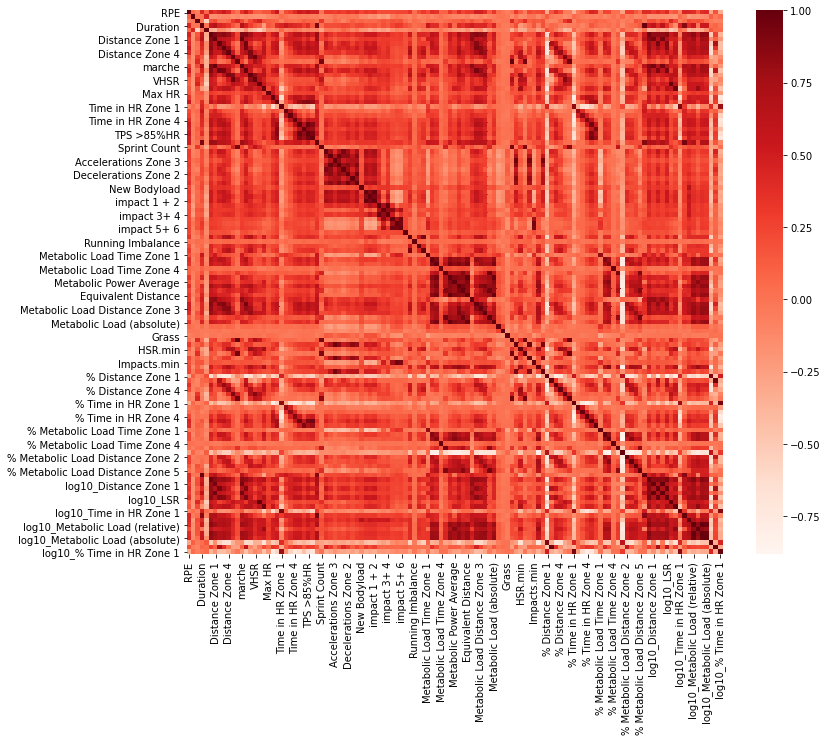

In [28]:
corr_matrix=data.corr()

plt.figure(figsize=(12,10))

sns.heatmap(corr_matrix, annot=False, cmap=plt.cm.Reds)
plt.show()

# Train, test split


Create a train/test split with the training set representing 67% of the data and the test set the remaining 33%.

In [29]:
from sklearn.model_selection import train_test_split

# Getting features...
X = data.loc[:, data.columns != 'RPE']

# ...and target
y = data["RPE"]

# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

We will now create multiple regression models and compare their RMSE value.

We will also use a Kolmogorov-Smirnov test to ensure normal distribution of residuals.

# Linear regression

## Full

In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy as sp
import scipy.stats as st

X = sm.add_constant(X) #  constant

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    RPE   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     19.22
Date:                Wed, 30 Sep 2020   Prob (F-statistic):          8.80e-242
Time:                        07:17:47   Log-Likelihood:                -2952.0
No. Observations:                2128   AIC:                             6130.
Df Residuals:                    2015   BIC:                             6770.
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [31]:
from sklearn import linear_model

# creating linear model
lr = linear_model.LinearRegression()

# training model
lr.fit(X_train,y_train)

# make prediction
y_pred = lr.predict(X_test)

from sklearn import metrics

# calculate RMSE
lr_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

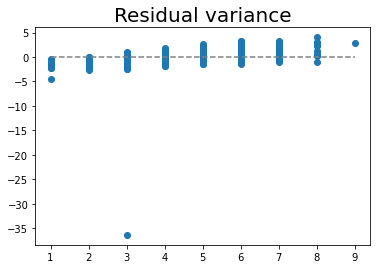

In [32]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df
df1 = df1.sort_values("Actual")
plt.scatter(df1.Actual,df1.Actual-df1.Predicted)
plt.title('Residual variance', size=20)
plt.hlines(0,min(df1.Actual),max(df1.Actual), color="gray", linestyles="--")
plt.show()

Text(0.5, 1.0, 'Histogram of residuals')

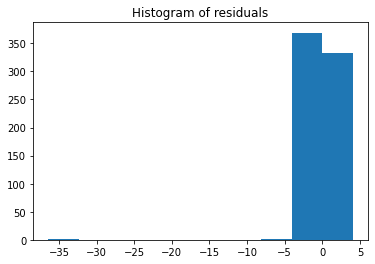

In [33]:
plt.hist(df1.Actual-df1.Predicted)
plt.title('Histogram of residuals')

In [34]:
#Kolmogorov-Smirnov
from scipy.stats import ks_2samp

# calculate KS p-value
lr_ks = ks_2samp(df1.Actual-df1.Predicted,list(np.random.normal(np.mean(df1.Actual-df1.Predicted), np.std(df1.Actual-df1.Predicted), 1000)))[1]

## Filter method

Filter method use correlation to select variables. Variables with corr > 0.5 are kept.

In [35]:
#Correlation with output variable
cor_target = abs(corr_matrix["RPE"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

RPE                  1.000000
Distance Zone 3      0.518897
LSR                  0.501149
HR Exertion          0.540188
Time in HR Zone 5    0.523540
TPS >85%HR           0.551665
Name: RPE, dtype: float64

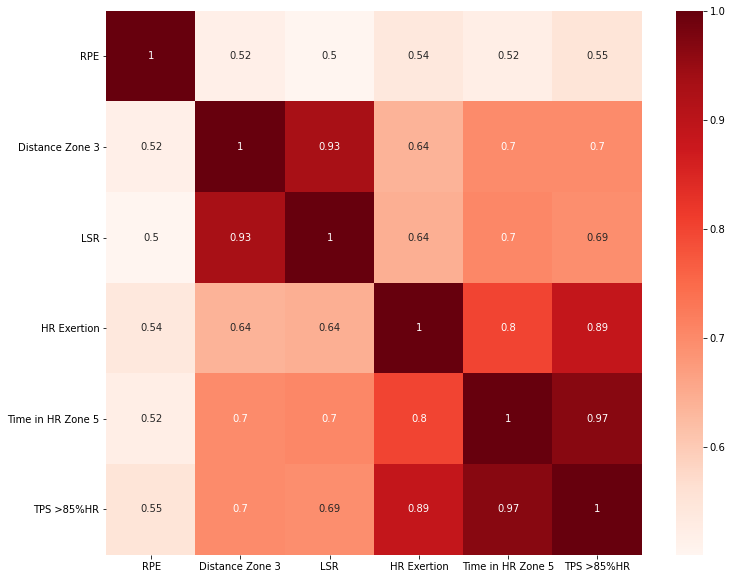

In [36]:
plt.figure(figsize=(12,10))
cor = data[["RPE","Distance Zone 3","LSR","HR Exertion","Time in HR Zone 5","TPS >85%HR"]].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [37]:
# Getting features...
X = X_train[["Distance Zone 3","TPS >85%HR"]]

# ... target
y = y_train

# building model
lrf = linear_model.LinearRegression()

# training model
lrf.fit(X,y)

# making prediction
y_pred = lrf.predict(X_test[["Distance Zone 3","TPS >85%HR"]])

# getting model RMSE
filter_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

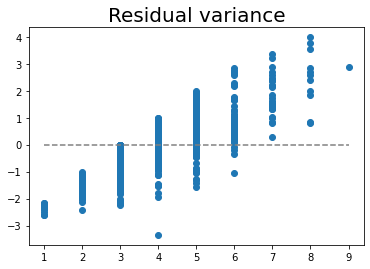

In [38]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df
df1 = df1.sort_values("Actual")
plt.scatter(df1.Actual,df1.Actual-df1.Predicted)
plt.title('Residual variance', size=20)
plt.hlines(0,min(df1.Actual),max(df1.Actual), color="gray", linestyles="--")
plt.show()

Text(0.5, 1.0, 'Histogram of residuals')

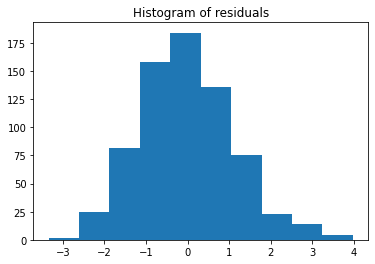

In [39]:
plt.hist(df1.Actual-df1.Predicted)
plt.title('Histogram of residuals')

In [40]:
# calculate KS p-value
filter_ks = ks_2samp(df1.Actual-df1.Predicted,list(np.random.normal(np.mean(df1.Actual-df1.Predicted), np.std(df1.Actual-df1.Predicted), 1000)))[1]

## Backward

We feed all the possible features to the model at first. We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range

In [41]:
# Getting features...
X = X_train

# ...and target
y = y_train

#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['Athlete', 'Position', 'Duration', 'Distance', 'Distance Zone 1', 'Distance Zone 2', 'Distance Zone 3', 'Distance Zone 4', 'Distance Zone 5', 'marche', 'Time in HR Zone 1', 'Time in HR Zone 4', 'Time in HR Zone 6', 'Accelerations Zone 2', 'Acc >2,5m/s²', 'Decelerations Zone 2', 'Dec <-2,5m/s²', 'impact 3+ 4', 'Impacts Zone 6', 'Running Imbalance Standard Deviation', 'Metabolic Load Time Zone 2', 'High-Metabolic-Power Distance', 'VHMPD', 'Grass', 'Sprint Total Distance', 'Sum_AD', '% Distance Zone 1', '% Distance Zone 2', '% Distance Zone 3', '% Distance Zone 4', '% Distance Zone 5', '% Distance Zone 6', '% Metabolic Load Time Zone 5', '% Metabolic Load Distance Zone 2', '% Metabolic Load Distance Zone 5', 'log10_Duration', 'log10_Distance', 'log10_Distance Zone 1', 'log10_Distance Zone 2', 'log10_marche', 'log10_M.min', 'log10_Time in HR Zone 1', 'log10_New Bodyload', 'log10_Metabolic Load (absolute)', 'log10_% Distance Zone 1', 'log10_% Distance Zone 2', 'log10_% Time in HR Zone 1']


In [42]:
# Number of features selected 
len(selected_features_BE)

47

In [43]:
# Getting features...
X = X_train.loc[:,selected_features_BE]

# ...and target
y = y_train

# build model
lrbw = linear_model.LinearRegression()

# train model
lrbw.fit(X,y)

# make prediction
y_pred = lrbw.predict(X_test.loc[:,selected_features_BE])

# calculate rmse
bw_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

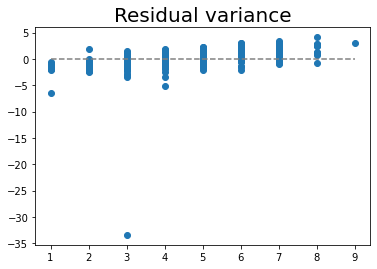

In [44]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df
df1 = df1.sort_values("Actual")
plt.scatter(df1.Actual,df1.Actual-df1.Predicted)
plt.title('Residual variance', size=20)
plt.hlines(0,min(df1.Actual),max(df1.Actual), color="gray", linestyles="--")
plt.show()

Text(0.5, 1.0, 'Histogram of residual')

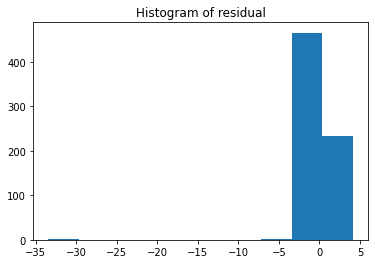

In [45]:
plt.hist(df1.Actual-df1.Predicted)
plt.title('Histogram of residual')

In [46]:
#Kolmogorov-Smirnov
bw_ks = ks_2samp(df1.Actual-df1.Predicted,list(np.random.normal(np.mean(df1.Actual-df1.Predicted), np.std(df1.Actual-df1.Predicted), 1000)))[1]

## RFE


The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance.

In [47]:
from sklearn.feature_selection import RFE

model = linear_model.LinearRegression()

# Getting features...
X = data.loc[:, data.columns != 'RPE']

# .. and target
y = data["RPE"]

#no of features
nof_list=np.arange(1,nb_feat)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = linear_model.LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)

Optimum number of features: 28


In [48]:
cols = list(X.columns)
model = linear_model.LinearRegression()
#Initializing RFE model
rfe = RFE(model, nof)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Distance Zone 1', 'Distance Zone 6', 'marche', 'VHSR',
       'Time in HR Zone 5', 'Time in HR Zone 6', 'TPS >85%HR', 'Sprint Count',
       'Accelerations Zone 2', 'Accelerations Zone 3', 'Acc >2,5m/s²',
       'Decelerations Zone 3', 'Impacts Zone 3', 'Impacts Zone 4',
       'impact 3+ 4', 'Sprint Total Distance', 'Sum_AD', 'Sp_acc',
       'log10_Duration', 'log10_Distance', 'log10_Distance Zone 1',
       'log10_Distance Zone 2', 'log10_marche', 'log10_M.min',
       'log10_Time in HR Zone 1', 'log10_% Distance Zone 1',
       'log10_% Distance Zone 2', 'log10_% Time in HR Zone 1'],
      dtype='object')


In [49]:
# Getting features...
X = X_train.loc[:,selected_features_rfe]

# ... and target
y = y_train

# build model
lr_rfe = linear_model.LinearRegression()

# train model
lr_rfe.fit(X,y)

# making prediction
y_pred = lr_rfe.predict(X_test.loc[:,selected_features_rfe])

# calculate rmse
rfe_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

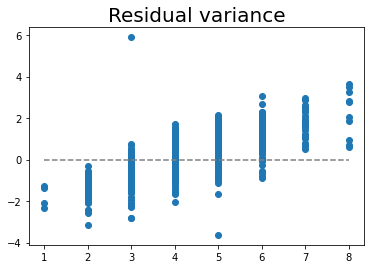

In [50]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df
df1 = df1.sort_values("Actual")
plt.scatter(df1.Actual,df1.Actual-df1.Predicted)
plt.title('Residual variance', size=20)
plt.hlines(0,min(df1.Actual),max(df1.Actual), color="gray", linestyles="--")
plt.show()

Text(0.5, 1.0, 'Histogram of residual')

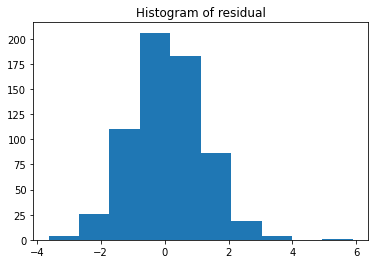

In [51]:
plt.hist(df1.Actual-df1.Predicted)
plt.title('Histogram of residual')

In [52]:
# calculate KS p-value
rfe_ks = ks_2samp(df1.Actual-df1.Predicted,list(np.random.normal(np.mean(df1.Actual-df1.Predicted), np.std(df1.Actual-df1.Predicted), 1000)))[1]

# Ridge

Ridge regression is a way to create a parsimonious model when the number of predictor variables in a set exceeds the number of observations, or when a data set has multicollinearity (correlations between predictor variables). The latter being our case here.

In [53]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

In [54]:
score = 'neg_root_mean_squared_error'

rcv = RidgeCV(scoring = score)

# train model with rfe selected features 
rcv.fit(X_train.loc[:,selected_features_rfe],y_train) 

# make prediction
y_pred = rcv.predict(X_test.loc[:,selected_features_rfe])

# calculate rmse
ridge_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

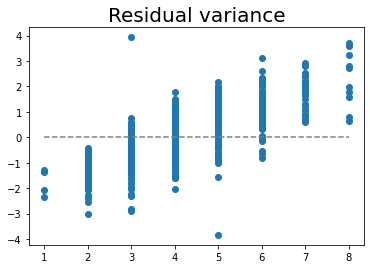

In [55]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df
df1 = df1.sort_values("Actual")
plt.scatter(df1.Actual,df1.Actual-df1.Predicted)
plt.title('Residual variance', size=20)
plt.hlines(0,min(df1.Actual),max(df1.Actual), color="gray", linestyles="--")
plt.show()

Text(0.5, 1.0, 'Histogram of residual')

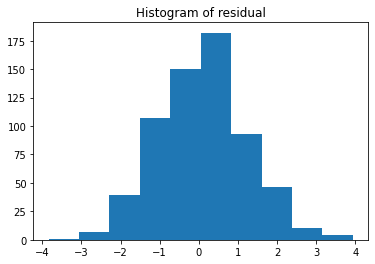

In [56]:
plt.hist(df1.Actual-df1.Predicted)
plt.title('Histogram of residual')

In [57]:
# calculate KS p-value
ridge_ks = ks_2samp(df1.Actual-df1.Predicted,list(np.random.normal(np.mean(df1.Actual-df1.Predicted), np.std(df1.Actual-df1.Predicted), 1000)))[1]

# Lasso

Here we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [58]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

# params
n_alphas = 300
alphas = np.logspace(-6, 0, n_alphas)

# build model
lcv = LassoCV(alphas=alphas, n_alphas = n_alphas)

# training model
lcv.fit(X_train,y_train)  

coef = pd.Series(lcv.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 65 variables and eliminated the other 55 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

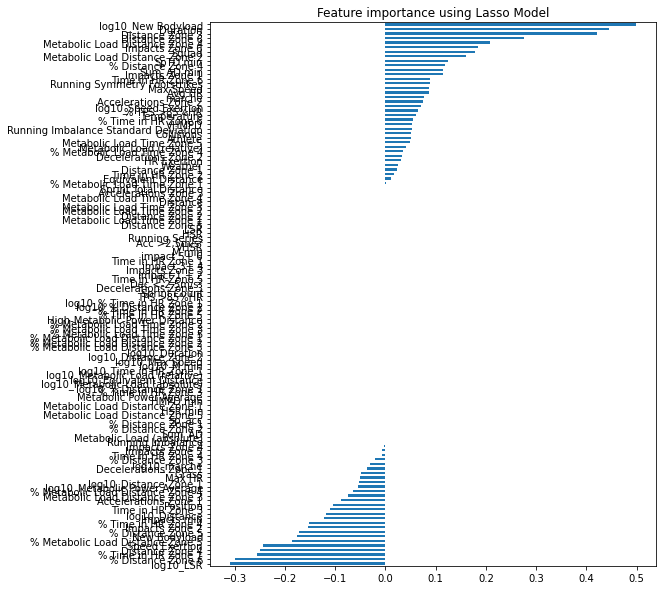

In [59]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [60]:
matplotlib.rcParams['figure.figsize'] = (6,4)

In [61]:
imp_coef[imp_coef != 0].index

Index(['log10_LSR', '% Distance Zone 6', '% Time in HR Zone 1',
       'Distance Zone 4', 'Speed Exertion', '% Metabolic Load Distance Zone 5',
       'New Bodyload', '% Distance Zone 5', 'Impacts Zone 2',
       '% Time in HR Zone 4', 'Impacts.min', 'log10_Distance',
       'Time in HR Zone 3', 'Position', 'Accelerations Zone 1',
       'Metabolic Load Distance Zone 3', '% Metabolic Load Distance Zone 4',
       'log10_Metabolic Power Average', 'log10_Distance Zone 1', 'Max HR',
       'Grass', 'Decelerations Zone 1', 'log10_marche', '% Distance Zone 3',
       'Time in HR Zone 4', 'Impacts Zone 5', 'Impacts Zone 4',
       'Running Imbalance', 'Sprint Total Distance',
       '% Metabolic Load Time Zone 1', 'Equivalent Distance',
       'Time in HR Zone 2', 'Distance Zone 1', 'Weather', 'HR Exertion',
       'Decelerations Zone 2', '% Metabolic Load Time Zone 4',
       'Metabolic Load (relative)', 'Metabolic Load Time Zone 5', 'Athlete',
       'Collisions', 'Running Imbalance Standa

In [62]:
# making prediction
y_pred = lcv.predict(X_test)

# calculate model rmse
lasso_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

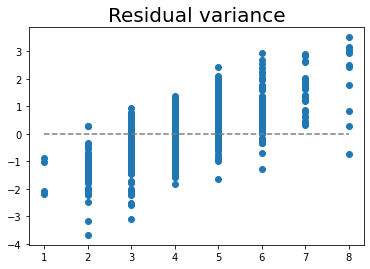

In [63]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df
df1 = df1.sort_values("Actual")
plt.scatter(df1.Actual,df1.Actual-df1.Predicted)
plt.title('Residual variance', size=20)
plt.hlines(0,min(df1.Actual),max(df1.Actual), color="gray", linestyles="--")
plt.show()

Text(0.5, 1.0, 'Histogram of residual')

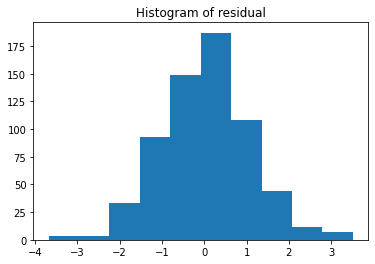

In [64]:
plt.hist(df1.Actual-df1.Predicted)
plt.title('Histogram of residual')

In [65]:
#Kolmogorov-Smirnov
lasso_ks = ks_2samp(df1.Actual-df1.Predicted,list(np.random.normal(np.mean(df1.Actual-df1.Predicted), np.std(df1.Actual-df1.Predicted), 1000)))[1]

# kNN Regressor

The KNN algorithm uses ‘feature similarity’ to predict the values of any new data points. This means that the new point is assigned a value based on how closely it resembles the points in the training set.

In [66]:
from sklearn import neighbors, metrics
from sklearn import model_selection

In [67]:
# nb of neighbors
nb_k = np.arange(1,25,1)

# params to test
param_grid = {'n_neighbors': nb_k}

# scoring choice : rmse
score = 'neg_root_mean_squared_error'

# making model
reg = model_selection.GridSearchCV(
    neighbors.KNeighborsRegressor(), #  regressor kNN
    param_grid,     
    cv=5,          
    scoring=score  
)

# train model
reg.fit(X_train, y_train)

# Show params
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(reg.best_params_)

# and perfs
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        reg.cv_results_['mean_test_score'], 
        reg.cv_results_['std_test_score'],  
        reg.cv_results_['params']           
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 8}
Résultats de la validation croisée :
neg_root_mean_squared_error = -1.198 (+/-0.079) for {'n_neighbors': 1}
neg_root_mean_squared_error = -1.053 (+/-0.078) for {'n_neighbors': 2}
neg_root_mean_squared_error = -1.020 (+/-0.041) for {'n_neighbors': 3}
neg_root_mean_squared_error = -1.007 (+/-0.038) for {'n_neighbors': 4}
neg_root_mean_squared_error = -1.007 (+/-0.032) for {'n_neighbors': 5}
neg_root_mean_squared_error = -1.002 (+/-0.026) for {'n_neighbors': 6}
neg_root_mean_squared_error = -0.998 (+/-0.022) for {'n_neighbors': 7}
neg_root_mean_squared_error = -0.997 (+/-0.017) for {'n_neighbors': 8}
neg_root_mean_squared_error = -0.998 (+/-0.016) for {'n_neighbors': 9}
neg_root_mean_squared_error = -1.002 (+/-0.023) for {'n_neighbors': 10}
neg_root_mean_squared_error = -1.006 (+/-0.035) for {'n_neighbors': 11}
neg_root_mean_squared_error = -1.002 (+/-0.032) for {'n_neighbors': 12}
neg_root_mean_squared_error = -1

In [68]:
# make prediction
y_pred = reg.predict(X_test)

# calculate model rmse
knn_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

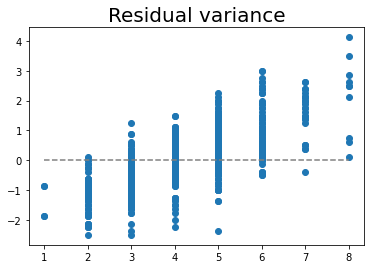

In [69]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df
df1 = df1.sort_values("Actual")
plt.scatter(df1.Actual,df1.Actual-df1.Predicted)
plt.title('Residual variance', size=20)
plt.hlines(0,min(df1.Actual),max(df1.Actual), color="gray", linestyles="--")
plt.show()

Text(0.5, 1.0, 'Histogram of residual')

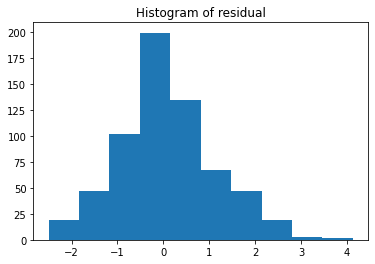

In [70]:
plt.hist(df1.Actual-df1.Predicted)
plt.title('Histogram of residual')

In [71]:
#Kolmogorov-Smirnov
knn_ks = ks_2samp(df1.Actual-df1.Predicted,list(np.random.normal(np.mean(df1.Actual-df1.Predicted), np.std(df1.Actual-df1.Predicted), 1000)))[1]

# NN

In [72]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


In [73]:
# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-pibd2_jm
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-pibd2_jm
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0d522e325039fbc2f6c77da1d5632affe634fd0e8_-cp36-none-any.whl size=143849 sha256=bbaabe87dbadc16e07407fecbb0707b789b8555081a39ecf4fd0a334a4f67d73
  Stored in directory: /tmp/pip-ephem-wheel-cache-8gniav_i/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [74]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [75]:
# create function to build model
def build_model():
  model = keras.Sequential([
    layers.Dense(64,activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(64,activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# build model
model = build_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                7744      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 11,969
Trainable params: 11,969
Non-trainable params: 0
_________________________________________________________________


In [76]:
EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train,y_train, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3.3040,  mae:1.4083,  mse:3.3040,  val_loss:2.1010,  val_mae:1.1434,  val_mse:2.1010,  
....................

In [77]:
# make prediction
y_pred = model.predict(X_test).flatten()

# Calculate model rmse
nn_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

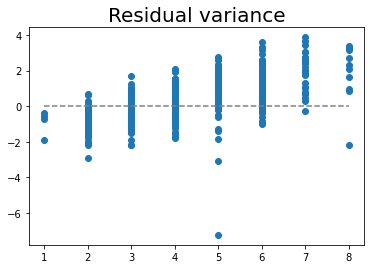

In [78]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df
df1 = df1.sort_values("Actual")
plt.scatter(df1.Actual,df1.Actual-df1.Predicted)
plt.title('Residual variance', size=20)
plt.hlines(0,min(df1.Actual),max(df1.Actual), color="gray", linestyles="--")
plt.show()

Text(0.5, 1.0, 'Histogram of residual')

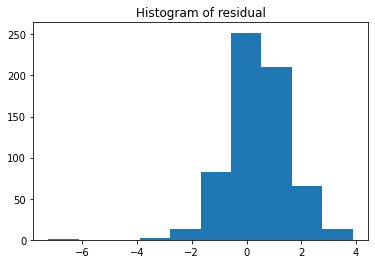

In [79]:
plt.hist(df1.Actual-df1.Predicted)
plt.title('Histogram of residual')

In [80]:
#Kolmogorov-Smirnov
nn_ks = ks_2samp(df1.Actual-df1.Predicted,list(np.random.normal(np.mean(df1.Actual-df1.Predicted), np.std(df1.Actual-df1.Predicted), 1000)))[1]

# Models scoring

Best model will be selected on RMSE and KS test p-value as we need normal distribution of residuals later on.

In [81]:
# create df for the results 
rmse = {'Model':['Linear_filter', 'Linear bw', 'Linear RFE', 'Ridge', "Lasso","kNN","NN"],
        'RMSE':[filter_rmse, bw_rmse, rfe_rmse, ridge_rmse,lasso_rmse,knn_rmse,nn_rmse],
        'KS':[filter_ks, bw_ks, rfe_ks, ridge_ks,lasso_ks,knn_ks,nn_ks]} 
  
# Create DataFrame 
df = pd.DataFrame(rmse) 
  
# Print the output. 
df

,Model,RMSE,KS
0,Linear_filter,1.132540,0.506903
1,Linear bw,1.688103,0.000005
2,Linear RFE,1.130336,0.406318
3,Ridge,1.120804,0.634971
4,Lasso,1.058469,0.707036
5,kNN,1.050002,0.039910
6,NN,1.192595,0.825545


All score are very close from each other. Result may probably vary from train/test split.

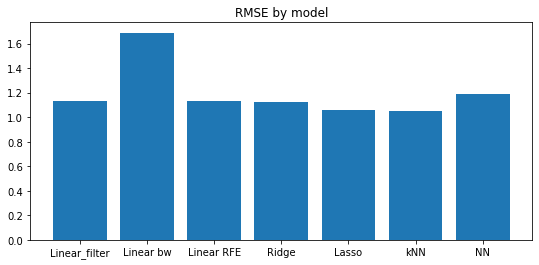

In [82]:
# ploting rmse score
plt.figure(figsize=(9,4))
plt.bar(df["Model"],df["RMSE"])
plt.title("RMSE by model")
plt.show()

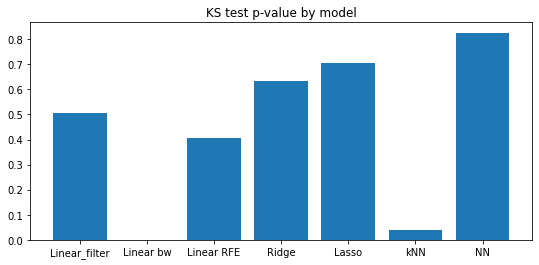

In [83]:
# plotting KS p-value
plt.figure(figsize=(9,4))
plt.bar(df["Model"],df["KS"])
plt.title("KS test p-value by model")
plt.show()

# In practice

We now will use one of the regression model we just build to predict RPE score for each observations.
We will use an Statistical Process Control (SPC) approach.
With normality of residuals, actual RPE score is expected to be in predicted RPE +/- error standar deviation 68% of the time.
Outside upper and lower limit, actual RPE score is unexpected. In SPC specific "rules" can be used if unexpected values occurs to many times in a short period. 


In [84]:
# make prediction 
predicted = model.predict(data.drop("RPE", axis = 1))

# calculate standar deviation of error
stdev = np.std(df1.Actual-df1.Predicted)
print(stdev)

1.1073102714727558


In [85]:
# prepare merging
temp = data_full[(data_full["Day Code"]!= "Game day") & (data_full["Day Code"]!= "Game" )]
temp = temp.reset_index()

# calculate upper and lower limit for spc
data["Predicted"] = predicted
data["lower_limit"] = data["Predicted"] - stdev
data["upper_limit"] = data["Predicted"] + stdev

data_rpe = data[["RPE","lower_limit","upper_limit"]]

# merge session data and rpe data
data_rpe = pd.concat([temp[["Athlete", "Date"]],data_rpe], axis = 1)
data_rpe.head(5)

,Athlete,Date,RPE,lower_limit,upper_limit
0,athlete 1,2014-07-21T00:00:00Z,3.0,1.912716,4.127337
1,athlete 1,2014-07-21T00:00:00Z,7.0,6.145825,8.360445
2,athlete 1,2014-07-28T00:00:00Z,4.0,2.448326,4.662946
3,athlete 1,2014-07-28T00:00:00Z,5.0,3.466493,5.681113
4,athlete 1,2014-07-22T00:00:00Z,3.0,2.116048,4.330668


Text(0.5, 1.0, 'Histogram of error')

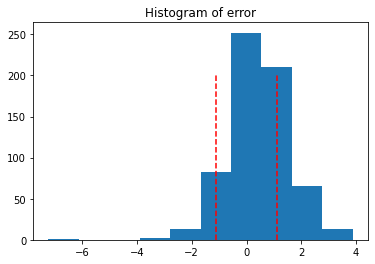

In [86]:
# plotting histogram of error
plt.hist(df1.Actual-df1.Predicted)
plt.vlines(-stdev, 0,200, colors="r", linestyles = "dashed")
plt.vlines(stdev, 0,200, colors="r", linestyles = "dashed")
plt.title('Histogram of error')

# Dashboard


A dashboard can be find here -> https://datastudio.google.com/s/o77E-A0ciAA